In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import re
import json

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Bidirectional,
    Conv1D,
    Dense,
    Flatten,
    Input,
    MaxPooling1D,
    TimeDistributed,
    Dropout
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

2024-08-21 16:24:46.025038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 16:24:46.046773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 16:24:46.052631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 16:24:46.066155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 16:24:47.350781: W tensorflow/compiler/tf2

### Evaluating

In [32]:
folder = Path("TCC_data/paper_trained_hand_feature_downsampled_200_filter_3")
model_name = "bidirectional"

In [33]:
# with open(folder/'processed_labeled_image_data.npy', 'rb') as f:
#     x_data = np.load(f)

# with open(folder/'processed_labeled_image_result.npy', 'rb') as f:
#     y_data = np.load(f)

In [34]:
with open(folder/'processed_labeled_filtered_normalized_data.npy', 'rb') as f:
    x_data = np.load(f)

with open(folder/'processed_labeled_filtered_normalized_result.npy', 'rb') as f:
    y_data = np.load(f)

In [35]:
# Open the JSON file and read the data back into a dictionary
with open(folder/'class_index.json', 'r') as json_file:
    class_index = json.load(json_file)

In [36]:
y_data_categorical = to_categorical(y_data,num_classes=np.unique(y_data).shape[0])

x_train, x_val, y_train, y_val = train_test_split(x_data,y_data_categorical,
                                                  test_size=0.3,
                                                  random_state=42,
                                                  stratify=y_data_categorical)

x_val, x_test, y_val, y_test = train_test_split(x_val,y_val,
                                                  test_size=0.34,
                                                  random_state=42,
                                                  stratify=y_val)

In [37]:
model = tf.keras.models.load_model(folder/f'best_{model_name}_model.keras')

# Display the model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200)            │        88,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,620 (1.02 MB)

 Trainable params: 89,206 (348.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 178,414 (696.93 KB)

Train

2802/2802 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Macro Precision: 0.743225649595023
Macro Recall: 0.7010387980034593
Accuracy: 0.7113295107204213
Micro Precision: 0.7113295107204213
Micro Recall: 0.7113295107204213


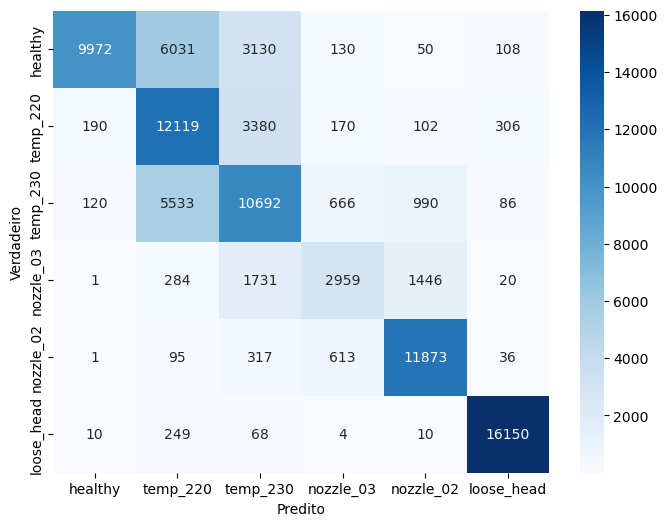

In [38]:
y_pred = model.predict(x_train)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_classes = np.argmax(y_train, axis=1)

# Calculate precision and recall for multi-class classification
macro_precision = precision_score(y_classes, y_pred_classes, average='macro')
macro_recall = recall_score(y_classes, y_pred_classes, average='macro')
macro_accuracy = accuracy_score(y_classes, y_pred_classes)

print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Accuracy: {macro_accuracy}")

# Calculate precision and recall for multi-class classification
micro_precision = precision_score(y_classes, y_pred_classes, average='micro')
micro_recall = recall_score(y_classes, y_pred_classes, average='micro')

print(f"Micro Precision: {micro_precision}")
print(f"Micro Recall: {micro_recall}")

# Create the confusion matrix
conf_matrix = confusion_matrix(y_classes, y_pred_classes)

# Convert to DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_index.keys(), columns=class_index.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.savefig(folder/f"confusion_matrix_train_{model_name}.png")
plt.show()

Validation

793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Macro Precision: 0.7203192189593414
Macro Recall: 0.680489311191968
Accuracy: 0.6933270231897776
Micro Precision: 0.6933270231897776
Micro Recall: 0.6933270231897776


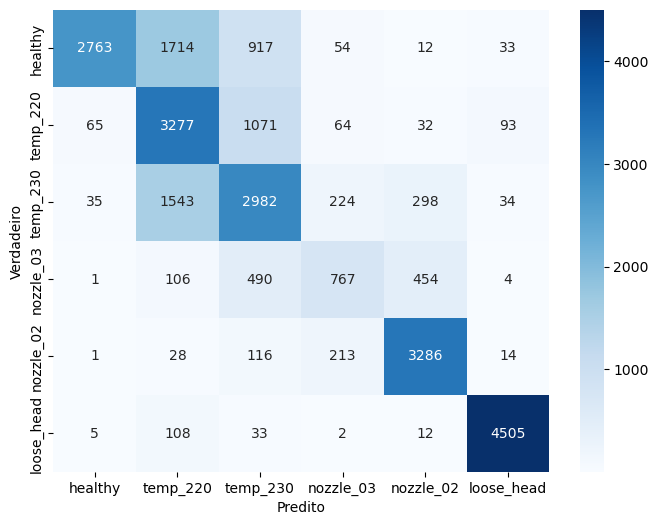

In [39]:
y_pred = model.predict(x_val)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_classes = np.argmax(y_val, axis=1)

# Calculate precision and recall for multi-class classification
macro_precision = precision_score(y_classes, y_pred_classes, average='macro')
macro_recall = recall_score(y_classes, y_pred_classes, average='macro')
accuracy = accuracy_score(y_classes, y_pred_classes)

print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Accuracy: {accuracy}")

# Calculate precision and recall for multi-class classification
micro_precision = precision_score(y_classes, y_pred_classes, average='micro')
micro_recall = recall_score(y_classes, y_pred_classes, average='micro')

print(f"Micro Precision: {micro_precision}")
print(f"Micro Recall: {micro_recall}")

with open(folder/f"results_{model_name}.txt", "w+") as f:
    f.write(f"\\newcommand{{\\{model_name.replace("_","")}MacroPrecision}}{{{macro_precision:0.4}}}\n")
    f.write(f"\\newcommand{{\\{model_name.replace("_","")}MacroRecall}}{{{macro_recall:0.4}}}\n")
    f.write(f"\\newcommand{{\\{model_name.replace("_","")}MicroPrecision}}{{{micro_precision:0.4}}}\n")
    f.write(f"\\newcommand{{\\{model_name.replace("_","")}MicroRecall}}{{{micro_recall:0.4}}}\n")
    f.write(f"\\newcommand{{\\{model_name.replace("_","")}Accuracy}}{{{accuracy:0.4}}}\n")

# Create the confusion matrix
conf_matrix = confusion_matrix(y_classes, y_pred_classes)

# Convert to DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_index.keys(), columns=class_index.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.savefig(folder/f"confusion_matrix_validation_{model_name}.png")
plt.show()

Test

In [40]:
# y_pred = model.predict(x_test)

# # Convert predictions to class labels
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_classes = np.argmax(y_test, axis=1)

# # Calculate precision and recall for multi-class classification
# macro_precision = precision_score(y_classes, y_pred_classes, average='macro')
# macro_recall = recall_score(y_classes, y_pred_classes, average='macro')
# accuracy = accuracy_score(y_classes, y_pred_classes)

# print(f"Macro Precision: {macro_precision}")
# print(f"Macro Recall: {macro_recall}")

# # Calculate precision and recall for multi-class classification
# micro_precision = precision_score(y_classes, y_pred_classes, average='micro')
# micro_recall = recall_score(y_classes, y_pred_classes, average='micro')

# print(f"Micro Precision: {micro_precision}")
# print(f"Micro Recall: {micro_recall}")

# with open(folder/f"results_teste.txt", "w+") as f:
#     f.write(f"\\newcommand{{\\TestMacroPrecision}}{{{macro_precision:0.4}}}\n")
#     f.write(f"\\newcommand{{\\TestMacroRecall}}{{{macro_recall:0.4}}}\n")
#     f.write(f"\\newcommand{{\\TestMicroPrecision}}{{{micro_precision:0.4}}}\n")
#     f.write(f"\\newcommand{{\\TestMicroRecall}}{{{micro_recall:0.4}}}\n")
#     f.write(f"\\newcommand{{\\TestAccuracy}}{{{accuracy:0.4}}}\n")

# # Create the confusion matrix
# conf_matrix = confusion_matrix(y_classes, y_pred_classes)

# # Convert to DataFrame for better readability
# conf_matrix_df = pd.DataFrame(conf_matrix, index=class_index.keys(), columns=class_index.keys())

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predito')
# plt.ylabel('Verdadeiro')
# plt.savefig(folder/f"confusion_matrix_test_{model_name}.png")
# plt.show()

#### History

In [41]:
# Path to the JSON file
file_path = folder/f'training_history_{model_name}.json'

# Read the JSON file
with open(file_path, 'r') as f:
    history = json.load(f)

# Print the training history
print(history.keys())

dict_keys(['accuracy', 'categorical_accuracy', 'loss', 'val_accuracy', 'val_categorical_accuracy', 'val_loss'])


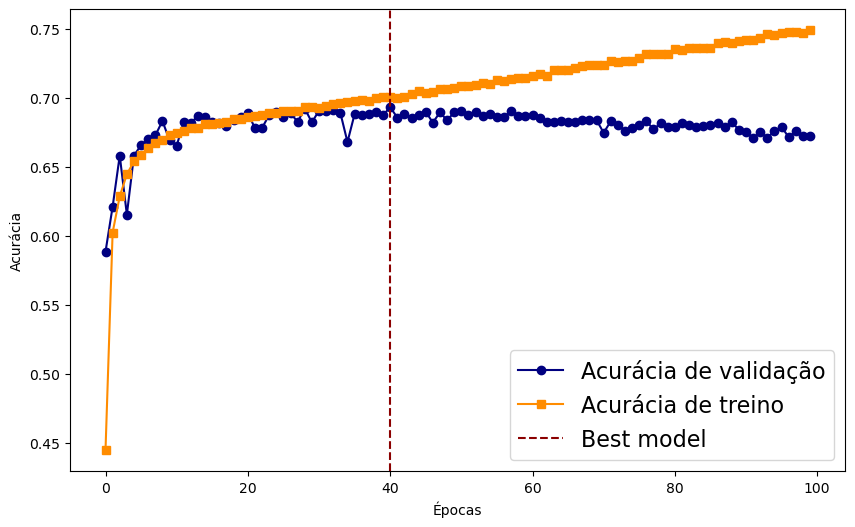

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(history["val_accuracy"], marker='o', linestyle='-', color='navy', label="Acurácia de validação")
plt.plot(history["accuracy"], marker='s', linestyle='-', color='darkorange', label="Acurácia de treino")
plt.axvline(x=np.array(history["val_accuracy"]).argmax(), color='darkred', linestyle='--', label='Best model')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.rcParams['legend.fontsize'] = 16
plt.legend()
plt.savefig(folder/f"train_epochs_{model_name}.png")
plt.show()